# Video Classification on CM

* Here we generate real-time classical music instruments information generator on classical music concert video input. 
* We basically adopt video classification method using pytorch, to classify what instrument is currently viewed on the screen. 
* Audience will receive the streaming video with information on it.

- - -

In [1]:
# importing required components 
import numpy as np
import pandas as pd
import torch
import os
import time
import json
import urllib
import random
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [3]:
from torch.optim import lr_scheduler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.layers.pooling import AveragePooling2D
from keras.applications import ResNet50
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.models import Model
from pickle import dump
from keras.optimizers import SGD
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from PIL import Image
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from efficientnet_pytorch import EfficientNet

In [4]:
# # importing remaining components
# import json
# import urllib
# from pytorchvideo.data.encoded_video import EncodedVideo

# from torchvision.transforms import Compose, Lambda
# from torchvision.transforms._transforms_video import (
#     CenterCropVideo,
#     NormalizeVideo,
# )
# from pytorchvideo.transforms import (
#     ApplyTransformToKey,
#     ShortSideScale,
#     UniformTemporalSubsample
# )

In [5]:
class Args:
    # arugments
    epochs=100
    bs=16
    lr=0.001
    momentum=0.9
    num_channels=3  # due to RGB channels(image)
    num_classes=17  # total 17 instruments labeled
    verbose='store_true'
    seed=710674

args = Args()    

np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)

In [6]:
#Setting torch environment

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device: ', DEVICE)

Using PyTorch version: 1.7.1  Device:  cuda


## Data Crawling for model training

* Here we create each folder for classical instruments that used in classical music concert
* bassdrum / bassoon / cello / clarinet / contrabass / cymbales / flute / horn / oboe / snaredrum / percussion / tamtam / timpani / trombone / trumpet / tuba / viola / violin -- total 17 instruments

### Image extraction from classical music concert video

- - -

In [ ]:
import cv2
from glob import glob

We are using orchestra symphony video as validation

In [ ]:
# ## Code for 
# def create_dir(path):
#     try:
#         if not os.path.exists(path):
#             os.makedirs(path)
#     except OSError:
#         print(f"ERROR: creating directory with name {path}")

# def save_frame(video_path, save_dir, gap=10):
#     name = video_path.split("/")[-1].split(".")[0]
#     save_path = os.path.join(save_dir, name)
#     create_dir(save_path)

#     cap = cv2.VideoCapture(video_path)
#     idx = 0

#     while True:
#         ret, frame = cap.read()

#         if ret == False:
#             cap.release()
#             break

#         if idx == 0:
#             cv2.imwrite(f"{save_path}/{idx}_Saint.png", frame)
#         else:
#             if idx % gap == 0:
#                 cv2.imwrite(f"{save_path}/{idx}_Saint.png", frame)

#         idx += 1

Extracting images

In [ ]:
# if __name__ == "__main__":
#     video_paths = glob("E:/RESEARCH/Datasets/VC/classic/videos/INPROCESS/*")
#     save_dir = "save"

#     for path in video_paths:
#         save_frame(path, save_dir, gap=50)

In [ ]:
# ## you have to end all windows before next step
# cv2.destroyAllWindows()

- - -

* Changing file names in directory

In [ ]:
# file_path = "E:/RESEARCH/Datasets/VC/classic/train/woodwinds"
# file_names = os.listdir(file_path)

In [ ]:
# i = 1
# for name in file_names:
#     src = os.path.join(file_path, name)
#     dst = str(i) + '.png'
#     dst = os.path.join(file_path, dst)
#     os.rename(src, dst)
#     i += 1

* Image Crop

In [ ]:
# im = Image.open(r"./test2.png")
 
# # Setting the points for cropped image
# left = 1000
# top = 200
# right =3000
# bottom = 3000
 
# # Cropped image of above dimension
# # (It will not change original image)
# im1 = im.crop((left, top, right, bottom))
 
# # Shows the image in image viewer
# im1.show()

- - -

## Training model preparation

* Selected Classical convert video: 
https://www.youtube.com/watch?v=65nvqmVhZ3g

* Our approach is train the model from image classification task, and apply it for the video classification. 
* So it is also possible to use pretrained models, such as, resnet, efficientnet

### Pre-trained models

In [ ]:
# ### Choose the `slowFAST_r50` pretrained model - for our video classification model training 
# ## slowfast net is for video classification. 
# model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

In [7]:
# model_res = models.resnet18(num_classes=2, pretrained=True)
model_eff3 = EfficientNet.from_pretrained('efficientnet-b3', num_classes=args.num_classes)
model_resnet18 = models.resnet18(pretrained=True)
model_mobnetv2 = models.mobilenet_v2(pretrained=True)

Loaded pretrained weights for efficientnet-b3


In [8]:
model_resnet18.fc = nn.Linear(in_features = 512, out_features = args.num_classes)
model_mobnetv2.classifier = nn.Linear(in_features = 1280, out_features=args.num_classes)

In [9]:
model_mobnetv2

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

### Simple CNN architecture

In [ ]:
## Designing simple CNN model architecture.
class CNN_vc(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_vc, self).__init__()

        def conv_batch(input_size, output_size, stride):
            return nn.Sequential(
                nn.Conv2d(input_size, output_size, 3, stride, 1, bias=False),
                nn.BatchNorm2d(output_size),
                nn.ReLU(inplace=True)
                )

        def conv_depth(input_size, output_size, stride):
            return nn.Sequential(
                nn.Conv2d(input_size, input_size, 3, stride, 1, groups=input_size, bias=False),
                nn.BatchNorm2d(input_size),
                nn.ReLU(inplace=True),
                
                nn.Conv2d(input_size, output_size, 1, 1, 0, bias=False),
                nn.BatchNorm2d(output_size),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_batch(3, 32, 2),
            conv_depth(32, 64, 1),
            conv_depth(64, 128, 2),
            conv_depth(128, 128, 1),
            conv_depth(128, 256, 2),
            conv_depth(256, 256, 1),
            conv_depth(256, 512, 2),
            conv_depth(512, 512, 1),
            conv_depth(512, 512, 1),
            conv_depth(512, 1024, 2),
            conv_depth(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
#         self.fc1 = nn.Linear(1024, 100)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
#         x = self.fc1(x)
        x = self.fc2(x)
        return x


* Finalize the training model

In [10]:
# model = model_eff3.to(DEVICE)
model = model_mobnetv2.to(DEVICE)
# model = model_resnet18.to(DEVICE)
# model = CNN_vc(args.num_channels, num_classes = args.num_classes).to(DEVICE)

## Image classification approach

* Generating classification model with image classification task.
* Then we can adop the model for video input, to figure out the instrument on the screen.

In [ ]:
def normalize_image(train_loader):

    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in train_loader:

        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

In [ ]:
# Data Transformation
data_transform_tensor = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
classic_data = datasets.ImageFolder(root = 'E:/RESEARCH/Datasets/VC/classic/origin/train', transform = data_transform_tensor)

In [ ]:
classic_mean, classic_std = normalize_image(train_loader)

In [ ]:
print(classic_mean, classic_std)

In [11]:
# Data Transformation
data_transforms = transforms.Compose([
#     transforms.CenterCrop(1024),
    transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
    transforms.ColorJitter(contrast=(0.3, 1), saturation=(0.3, 1)),
    transforms.ToTensor(),
    transforms.Normalize([0.2323, 0.17, 0.1409], [0.2197, 0.1874, 0.1709])
])

In [12]:
# Uploading image data
# classic_data = datasets.ImageFolder(root = 'E:/RESEARCH/Datasets/VC/classic/train', transform = data_transforms)
classic_data = datasets.ImageFolder(root = 'E:/RESEARCH/Datasets/VC/classic/origin/train', transform = data_transforms)

In [13]:
train_size = int(0.8 * len(classic_data))
test_size = len(classic_data)-train_size
print(train_size)
print(test_size)

3099
775


In [14]:
train_dataset, test_dataset = torch.utils.data.random_split(classic_data, [train_size, test_size])

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.bs, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.bs, shuffle=False, num_workers=4)

In [16]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([12, 11,  7, 12, 11, 11, 15, 15,  7, 11, 16, 12, 11, 16,  3, 14])


In [17]:
# Setting Optimizer and Objective Function

# optimizer = torch.optim.Adam(model.parameters(), lr = args.lr)
optimizer = torch.optim.SGD(model.parameters(), lr = args.lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, total_steps=args.epochs, anneal_strategy='cos')
criterion = nn.CrossEntropyLoss() ## setup the loss function

# print(model)

In [18]:
# Function for checking model performance during CNN model

def train(model, train_loader, optimizer, log_interval):
    model.train()
    print(optimizer.param_groups[0]['lr'])
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

#     scheduler.step() #for learning rate scheduler

In [19]:
# Function for checking model performance during the learning process

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    validation =[]

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader)) 
    validation_accuracy = 100. * correct / len(test_loader.dataset)
    validation.append(validation_accuracy)
    
    return test_loss, validation_accuracy

In [20]:
# Checking train, val loss and accuracy

test_los_total = []
vali_acc_total = []

for epoch in range(1, args.epochs):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, validation_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tValidation Accuracy: {:.2f} % \n".format(
        epoch, test_loss, validation_accuracy))
    
    test_los_total.append(test_loss)
    vali_acc_total.append(validation_accuracy)

0.00019999999999999966
Train Epoch: 1 [0/3099 (0%)]	Train Loss: 2.891830

[EPOCH: 1], 	Test Loss: 1.2802, 	Validation Accuracy: 62.84 % 

0.00019999999999999966
Train Epoch: 2 [0/3099 (0%)]	Train Loss: 1.343930

[EPOCH: 2], 	Test Loss: 0.8593, 	Validation Accuracy: 76.26 % 

0.00019999999999999966
Train Epoch: 3 [0/3099 (0%)]	Train Loss: 1.022624

[EPOCH: 3], 	Test Loss: 0.7384, 	Validation Accuracy: 77.16 % 

0.00019999999999999966
Train Epoch: 4 [0/3099 (0%)]	Train Loss: 0.440262

[EPOCH: 4], 	Test Loss: 0.5500, 	Validation Accuracy: 82.84 % 

0.00019999999999999966
Train Epoch: 5 [0/3099 (0%)]	Train Loss: 1.088679

[EPOCH: 5], 	Test Loss: 0.4918, 	Validation Accuracy: 84.00 % 

0.00019999999999999966
Train Epoch: 6 [0/3099 (0%)]	Train Loss: 0.421765

[EPOCH: 6], 	Test Loss: 0.4716, 	Validation Accuracy: 84.77 % 

0.00019999999999999966
Train Epoch: 7 [0/3099 (0%)]	Train Loss: 0.601386

[EPOCH: 7], 	Test Loss: 0.4332, 	Validation Accuracy: 86.71 % 

0.00019999999999999966
Train Epoch

In [21]:
print(test_los_total)
print(vali_acc_total)

[1.2801725663700882, 0.8593062814705226, 0.7383979729243687, 0.5500261832256707, 0.49181988500818913, 0.47157030507009856, 0.43322575609294733, 0.42359600421421384, 0.3621944221762978, 0.330819713788069, 0.34547538785453963, 0.31099205730216845, 0.3075598415595536, 0.31156537385315314, 0.2562847627060754, 0.3264656411293818, 0.30456830276062297, 0.2757387005400901, 0.23417408207469448, 0.26715616496013744, 0.2683020085286425, 0.2640730878813382, 0.2536443588418924, 0.24674962569332246, 0.2800112431678845, 0.21599147595199092, 0.27034028059783943, 0.22888696007430553, 0.24175496931586946, 0.2536310353553949, 0.25281198949990225, 0.23289316755301337, 0.22320973142335304, 0.21908950596591648, 0.2148118782788515, 0.2315182132475382, 0.22451713413228186, 0.22362449361315492, 0.2032218366452702, 0.24498014336413876, 0.28204247689026657, 0.18651603364708777, 0.21733534337990745, 0.20620695268260125, 0.225987048097411, 0.2282180907394813, 0.21419780427228888, 0.18928615038036084, 0.21209690177

- - -

## Model Performances

Performance Measure Explanations

* Sensitivity = TP/(TP+FN) = (Number of true positive assessment) / (Number of all posi tive assessment)
* Specificity = TN/(TN + FP) = (Number of true negative assessment)/(Number of all negative assessment)
* Accuracy = (TN + TP)/(TN+TP+FN+FP) = (Number of correct assessments)/Number of all assessments)

### Confusion Matrix

Text(0.5, 114.0, 'Predicted label')

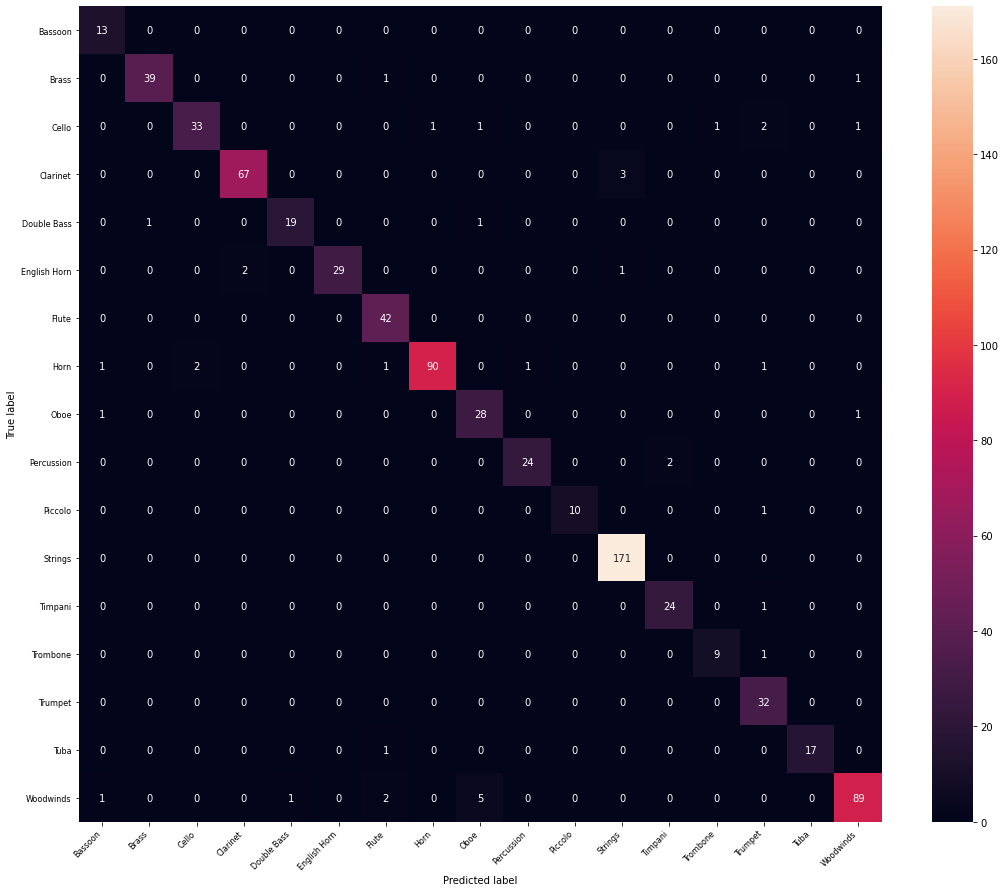

In [22]:
nb_classes = args.num_classes
confusion_matrix = np.zeros((nb_classes, nb_classes))
classes = {
    "0": "Bassoon",     "1": "Brass",        "2": "Cello",    "3": "Clarinet",
    "4": "Double Bass", "5": "English Horn", "6": "Flute",    "7": "Horn",
    "8": "Oboe",        "9": "Percussion",   "10": "Piccolo", "11": "Strings",
    "12": "Timpani",    "13": "Trombone",    "14": "Trumpet", "15": "Tuba",
    "16": "Woodwinds"
}

with torch.no_grad():
    for i, (image, label) in enumerate(test_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(18,15))
# print(confusion_matrix)

class_names = list(classes.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=8)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig('Classical Music_VC_output.png')

### Accuracy and Sensitivity

In [23]:
cm = confusion_matrix
total = sum(sum(cm))
print("Total number of test data is: ", total)

## Accuracy
acc = (cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+cm[8,8]+
       cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+cm[16,16]) / total

print("Overall classification accuracy is :", round(acc, 4))


## Sensitivity for each instrument classes
sen_bassoon = cm[0,0] / (cm[0,0]+cm[0,1]+cm[0,2]+cm[0,3]+cm[0,4]+cm[0,5]+cm[0,6]+
                         cm[0,7]+cm[0,8]+cm[0,9]+cm[0,10]+cm[0,11]+cm[0,12]+cm[0,13]+
                         cm[0,14]+cm[0,15]+cm[0,16])

sen_brass = cm[1,1] / (cm[1,0]+cm[1,1]+cm[1,2]+cm[1,3]+cm[1,4]+cm[1,5]+cm[1,6]+
                         cm[1,7]+cm[1,8]+cm[1,9]+cm[1,10]+cm[1,11]+cm[1,12]+cm[1,13]+
                         cm[1,14]+cm[1,15]+cm[1,16])

sen_cello = cm[2,2] / (cm[2,0]+cm[2,1]+cm[2,2]+cm[2,3]+cm[2,4]+cm[2,5]+cm[2,6]+
                         cm[2,7]+cm[2,8]+cm[2,9]+cm[2,10]+cm[2,11]+cm[2,12]+cm[2,13]+
                         cm[2,14]+cm[2,15]+cm[2,16])

sen_clarinet = cm[3,3] / (cm[3,0]+cm[3,1]+cm[3,2]+cm[3,3]+cm[3,4]+cm[3,5]+cm[3,6]+
                         cm[3,7]+cm[3,8]+cm[3,9]+cm[3,10]+cm[3,11]+cm[3,12]+cm[3,13]+
                         cm[3,14]+cm[3,15]+cm[3,16])

sen_doublebass = cm[4,4] / (cm[4,0]+cm[4,1]+cm[4,2]+cm[4,3]+cm[4,4]+cm[4,5]+cm[4,6]+
                         cm[4,7]+cm[4,8]+cm[4,9]+cm[4,10]+cm[4,11]+cm[4,12]+cm[4,13]+
                         cm[4,14]+cm[4,15]+cm[4,16])

sen_englishhorn = cm[5,5] / (cm[5,0]+cm[5,1]+cm[5,2]+cm[5,3]+cm[5,4]+cm[5,5]+cm[5,6]+
                         cm[5,7]+cm[5,8]+cm[5,9]+cm[5,10]+cm[5,11]+cm[5,12]+cm[5,13]+
                         cm[5,14]+cm[5,15]+cm[5,16])

sen_flute = cm[6,6] / (cm[6,0]+cm[6,1]+cm[6,2]+cm[6,3]+cm[6,4]+cm[6,5]+cm[6,6]+
                         cm[6,7]+cm[6,8]+cm[6,9]+cm[6,10]+cm[6,11]+cm[6,12]+cm[6,13]+
                         cm[6,14]+cm[6,15]+cm[6,16])

sen_horn = cm[7,7] / (cm[7,0]+cm[7,1]+cm[7,2]+cm[7,3]+cm[7,4]+cm[7,5]+cm[7,6]+
                         cm[7,7]+cm[7,8]+cm[7,9]+cm[7,10]+cm[7,11]+cm[7,12]+cm[7,13]+
                         cm[7,14]+cm[7,15]+cm[7,16])

sen_oboe = cm[8,8] / (cm[8,0]+cm[8,1]+cm[8,2]+cm[8,3]+cm[8,4]+cm[8,5]+cm[8,6]+
                         cm[8,7]+cm[8,8]+cm[8,9]+cm[8,10]+cm[8,11]+cm[8,12]+cm[8,13]+
                         cm[8,14]+cm[8,15]+cm[8,16])

sen_percussion = cm[9,9] / (cm[9,0]+cm[9,1]+cm[9,2]+cm[9,3]+cm[9,4]+cm[9,5]+cm[9,6]+
                         cm[9,7]+cm[9,8]+cm[9,9]+cm[9,10]+cm[9,11]+cm[9,12]+cm[9,13]+
                         cm[9,14]+cm[9,15]+cm[9,16])

sen_piccolo=cm[10,10] / (cm[10,0]+cm[10,1]+cm[10,2]+cm[10,3]+cm[10,4]+cm[10,5]+cm[10,6]+
                         cm[10,7]+cm[10,8]+cm[10,9]+cm[10,10]+cm[10,11]+cm[10,12]+cm[10,13]+
                         cm[10,14]+cm[10,15]+cm[10,16])

sen_strings=cm[11,11] / (cm[11,0]+cm[11,1]+cm[11,2]+cm[11,3]+cm[11,4]+cm[11,5]+cm[11,6]+
                         cm[11,7]+cm[11,8]+cm[11,9]+cm[11,10]+cm[11,11]+cm[11,12]+cm[11,13]+
                         cm[11,14]+cm[11,15]+cm[11,16])

sen_timpani=cm[12,12] / (cm[12,0]+cm[12,1]+cm[12,2]+cm[12,3]+cm[12,4]+cm[12,5]+cm[12,6]+
                         cm[12,7]+cm[12,8]+cm[12,9]+cm[12,10]+cm[12,11]+cm[12,12]+cm[12,13]+
                         cm[12,14]+cm[12,15]+cm[12,16])

sen_trombone=cm[13,13] / (cm[13,0]+cm[13,1]+cm[13,2]+cm[13,3]+cm[13,4]+cm[13,5]+cm[13,6]+
                         cm[13,7]+cm[13,8]+cm[13,9]+cm[13,10]+cm[13,11]+cm[13,12]+cm[13,13]+
                         cm[13,14]+cm[13,15]+cm[13,16])

sen_trumpet=cm[14,14] / (cm[14,0]+cm[14,1]+cm[14,2]+cm[14,3]+cm[14,4]+cm[14,5]+cm[14,6]+
                         cm[14,7]+cm[14,8]+cm[14,9]+cm[14,10]+cm[14,11]+cm[14,12]+cm[14,13]+
                         cm[14,14]+cm[14,15]+cm[14,16])

sen_tuba=cm[15,15] / (cm[15,0]+cm[15,1]+cm[15,2]+cm[15,3]+cm[15,4]+cm[15,5]+cm[15,6]+
                         cm[15,7]+cm[15,8]+cm[15,9]+cm[15,10]+cm[15,11]+cm[15,12]+cm[15,13]+
                         cm[15,14]+cm[15,15]+cm[15,16])

sen_woodwinds=cm[16,16] / (cm[16,0]+cm[16,1]+cm[16,2]+cm[16,3]+cm[16,4]+cm[16,5]+cm[16,6]+
                         cm[16,7]+cm[16,8]+cm[16,9]+cm[16,10]+cm[16,11]+cm[16,12]+cm[16,13]+
                         cm[16,14]+cm[16,15]+cm[16,16])


print("sensitivity of Bassoon class is :", round(sen_bassoon, 4))
print("sensitivity of Brass class is :", round(sen_brass,4))
print("sensitivity of Cello class is :", round(sen_cello,4))
print("sensitivity of Clarinet class is :", round(sen_clarinet, 4))
print("sensitivity of Double Bass class is :", round(sen_doublebass,4))
print("sensitivity of English Horn class is :", round(sen_englishhorn,4))
print("sensitivity of Flute class is :", round(sen_flute, 4))
print("sensitivity of Horn class is :", round(sen_horn,4))
print("sensitivity of Oboe class is :", round(sen_oboe,4))
print("sensitivity of Percussion class is :", round(sen_percussion, 4))
print("sensitivity of Piccolo class is :", round(sen_piccolo,4))
print("sensitivity of Strings class is :", round(sen_strings,4))
print("sensitivity of Timpani class is :", round(sen_timpani, 4))
print("sensitivity of Trombone class is :", round(sen_trombone,4))
print("sensitivity of Trumpet class is :", round(sen_trumpet,4))
print("sensitivity of Tuba class is :", round(sen_tuba, 4))
print("sensitivity of Woodwinds class is :", round(sen_woodwinds,4))

Total number of test data is:  775.0
Overall classification accuracy is : 0.9497
sensitivity of Bassoon class is : 1.0
sensitivity of Brass class is : 0.9512
sensitivity of Cello class is : 0.8462
sensitivity of Clarinet class is : 0.9571
sensitivity of Double Bass class is : 0.9048
sensitivity of English Horn class is : 0.9062
sensitivity of Flute class is : 1.0
sensitivity of Horn class is : 0.9375
sensitivity of Oboe class is : 0.9333
sensitivity of Percussion class is : 0.9231
sensitivity of Piccolo class is : 0.9091
sensitivity of Strings class is : 1.0
sensitivity of Timpani class is : 0.96
sensitivity of Trombone class is : 0.9
sensitivity of Trumpet class is : 1.0
sensitivity of Tuba class is : 0.9444
sensitivity of Woodwinds class is : 0.9082


### Specificity

In [24]:
## Specificity for each instrument classes: TN/(TN + FP)
spe_bas=(cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+cm[8,8]+
         cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[1,0]+cm[2,0]+cm[3,0]+cm[4,0]+cm[5,0]+cm[6,0]+cm[7,0]+
                       cm[8,0]+cm[9,0]+cm[10,0]+cm[11,0]+cm[12,0]+cm[13,0]+cm[14,0]+
                       cm[15,0]+cm[16,0] + 
                       cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
                       cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_bra=(cm[0,0]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+cm[8,8]+
         cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,1]+cm[2,1]+cm[3,1]+cm[4,1]+cm[5,1]+cm[6,1]+cm[7,1]+
                       cm[8,1]+cm[9,1]+cm[10,1]+cm[11,1]+cm[12,1]+cm[13,1]+cm[14,1]+
                       cm[15,1]+cm[16,1] + 
                       cm[0,0]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
                       cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_cel=(cm[0,0]+cm[1,1]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+cm[8,8]+
         cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,2]+cm[1,2]+cm[3,2]+cm[4,2]+cm[5,2]+cm[6,2]+cm[7,2]+
                       cm[8,2]+cm[9,2]+cm[10,2]+cm[11,2]+cm[12,2]+cm[13,2]+cm[14,2]+
                       cm[15,2]+cm[16,2] + 
                       cm[0,0]+cm[1,1]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
                       cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_cla=(cm[0,0]+cm[1,1]+cm[2,2]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+cm[8,8]+
         cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,3]+cm[1,3]+cm[2,3]+cm[4,3]+cm[5,3]+cm[6,3]+cm[7,3]+
                       cm[8,3]+cm[9,3]+cm[10,3]+cm[11,3]+cm[12,3]+cm[13,3]+cm[14,3]+
                       cm[15,3]+cm[16,3] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
                       cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_dou=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[5,5]+cm[6,6]+cm[7,7]+cm[8,8]+
         cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,4]+cm[1,4]+cm[2,4]+cm[3,4]+cm[5,4]+cm[6,4]+cm[7,4]+
                       cm[8,4]+cm[9,4]+cm[10,4]+cm[11,4]+cm[12,4]+cm[13,4]+cm[14,4]+
                       cm[15,4]+cm[16,4] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[5,5]+cm[6,6]+cm[7,7]+
                       cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_eng=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[6,6]+cm[7,7]+cm[8,8]+
         cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,5]+cm[1,5]+cm[2,5]+cm[3,5]+cm[4,5]+cm[6,5]+cm[7,5]+
                       cm[8,5]+cm[9,5]+cm[10,5]+cm[11,5]+cm[12,5]+cm[13,5]+cm[14,5]+
                       cm[15,5]+cm[16,5] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[6,6]+cm[7,7]+
                       cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_flu=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[7,7]+cm[8,8]+
         cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,6]+cm[1,6]+cm[2,6]+cm[3,6]+cm[4,6]+cm[5,6]+cm[7,6]+
                       cm[8,6]+cm[9,6]+cm[10,6]+cm[11,6]+cm[12,6]+cm[13,6]+cm[14,6]+
                       cm[15,6]+cm[16,6] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[7,7]+
                       cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_hor=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[8,8]+
         cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,7]+cm[1,7]+cm[2,7]+cm[3,7]+cm[4,7]+cm[5,7]+cm[6,7]+
                       cm[8,7]+cm[9,7]+cm[10,7]+cm[11,7]+cm[12,7]+cm[13,7]+cm[14,7]+
                       cm[15,7]+cm[16,7] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+
                       cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_obo=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
         cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,8]+cm[1,8]+cm[2,8]+cm[3,8]+cm[4,8]+cm[5,8]+cm[6,8]+
                       cm[7,8]+cm[9,8]+cm[10,8]+cm[11,8]+cm[12,8]+cm[13,8]+cm[14,8]+
                       cm[15,8]+cm[16,8] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+
                       cm[7,7]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_per=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
         cm[8,8]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,9]+cm[1,9]+cm[2,9]+cm[3,9]+cm[4,9]+cm[5,9]+cm[6,9]+
                       cm[7,9]+cm[8,9]+cm[10,9]+cm[11,9]+cm[12,9]+cm[13,9]+cm[14,9]+
                       cm[15,9]+cm[16,9] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+
                       cm[7,7]+cm[8,8]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_pic=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
         cm[8,8]+cm[9,9]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,10]+cm[1,10]+cm[2,10]+cm[3,10]+cm[4,10]+cm[5,10]+cm[6,10]+
                       cm[7,10]+cm[8,10]+cm[9,10]+cm[11,10]+cm[12,10]+cm[13,10]+cm[14,10]+
                       cm[15,10]+cm[16,10] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+
                       cm[7,7]+cm[8,8]+cm[9,9]+cm[11,11]+cm[12,12]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_str=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
         cm[8,8]+cm[9,9]+cm[10,10]+cm[12,12]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,11]+cm[1,11]+cm[2,11]+cm[3,11]+cm[4,11]+cm[5,11]+cm[6,11]+
                       cm[7,11]+cm[8,11]+cm[9,11]+cm[10,11]+cm[12,11]+cm[13,11]+cm[14,11]+
                       cm[15,11]+cm[16,11] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+
                       cm[7,7]+cm[8,8]+cm[9,9]+cm[10,10]+cm[12,12]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_tim=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
         cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[13,13]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,12]+cm[1,12]+cm[2,12]+cm[3,12]+cm[4,12]+cm[5,12]+cm[6,12]+
                       cm[7,12]+cm[8,12]+cm[9,12]+cm[10,12]+cm[11,12]+cm[13,12]+cm[14,12]+
                       cm[15,12]+cm[16,12] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+
                       cm[7,7]+cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[13,13]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_tro=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
         cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[14,14]+cm[15,15]+
         cm[16,16]) / (cm[0,13]+cm[1,13]+cm[2,13]+cm[3,13]+cm[4,13]+cm[5,13]+cm[6,13]+
                       cm[7,13]+cm[8,13]+cm[9,13]+cm[10,13]+cm[11,13]+cm[12,13]+cm[14,13]+
                       cm[15,13]+cm[16,13] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+
                       cm[7,7]+cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+
                       cm[14,14]+cm[15,15]+cm[16,16])

spe_tru=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
         cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[15,15]+
         cm[16,16]) / (cm[0,14]+cm[1,14]+cm[2,14]+cm[3,14]+cm[4,14]+cm[5,14]+cm[6,14]+
                       cm[7,14]+cm[8,14]+cm[9,14]+cm[10,14]+cm[11,14]+cm[12,14]+cm[13,14]+
                       cm[15,14]+cm[16,14] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+
                       cm[7,7]+cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+
                       cm[13,13]+cm[15,15]+cm[16,16])

spe_tub=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
         cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+
         cm[16,16]) / (cm[0,15]+cm[1,15]+cm[2,15]+cm[3,15]+cm[4,15]+cm[5,15]+cm[6,15]+
                       cm[7,15]+cm[8,15]+cm[9,15]+cm[10,15]+cm[11,15]+cm[12,15]+cm[13,15]+
                       cm[14,15]+cm[16,15] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+
                       cm[7,7]+cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+
                       cm[13,13]+cm[14,14]+cm[16,16])

spe_woo=(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+cm[7,7]+
         cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+cm[13,13]+cm[14,14]+
         cm[15,15]) / (cm[0,16]+cm[1,16]+cm[2,16]+cm[3,16]+cm[4,16]+cm[5,16]+cm[6,16]+
                       cm[7,16]+cm[8,16]+cm[9,16]+cm[10,16]+cm[11,16]+cm[12,16]+cm[13,16]+
                       cm[14,16]+cm[15,16] + 
                       cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5]+cm[6,6]+
                       cm[7,7]+cm[8,8]+cm[9,9]+cm[10,10]+cm[11,11]+cm[12,12]+
                       cm[13,13]+cm[14,14]+cm[15,15])


print("specificity of Basson class is :", round(spe_bas,4))
print("specificity of Brass class is :", round(spe_bra,4))
print("specificity of Cello class is :", round(spe_cel,4))
print("specificity of Clarinet class is :", round(spe_cla,4))
print("specificity of Double Bass class is :", round(spe_dou,4))
print("specificity of English Horn class is :", round(spe_eng,4))
print("specificity of Flute class is :", round(spe_flu,4))
print("specificity of Horn class is :", round(spe_hor,4))
print("specificity of Oboe class is :", round(spe_obo,4))
print("specificity of Percussion class is :", round(spe_per,4))
print("specificity of Piccolo class is :", round(spe_pic,4))
print("specificity of Strings class is :", round(spe_str,4))
print("specificity of Timpani class is :", round(spe_tim,4))
print("specificity of Trombone class is :", round(spe_tro,4))
print("specificity of Trumpet class is :", round(spe_tru,4))
print("specificity of Tuba class is :", round(spe_tub,4))
print("specificity of Woodwinds class is :", round(spe_woo,4))

specificity of Basson class is : 0.9959
specificity of Brass class is : 0.9986
specificity of Cello class is : 0.9972
specificity of Clarinet class is : 0.997
specificity of Double Bass class is : 0.9986
specificity of English Horn class is : 1.0
specificity of Flute class is : 0.9928
specificity of Horn class is : 0.9985
specificity of Oboe class is : 0.9902
specificity of Percussion class is : 0.9986
specificity of Piccolo class is : 1.0
specificity of Strings class is : 0.993
specificity of Timpani class is : 0.9972
specificity of Trombone class is : 0.9986
specificity of Trumpet class is : 0.9915
specificity of Tuba class is : 1.0
specificity of Woodwinds class is : 0.9954


### Graphs

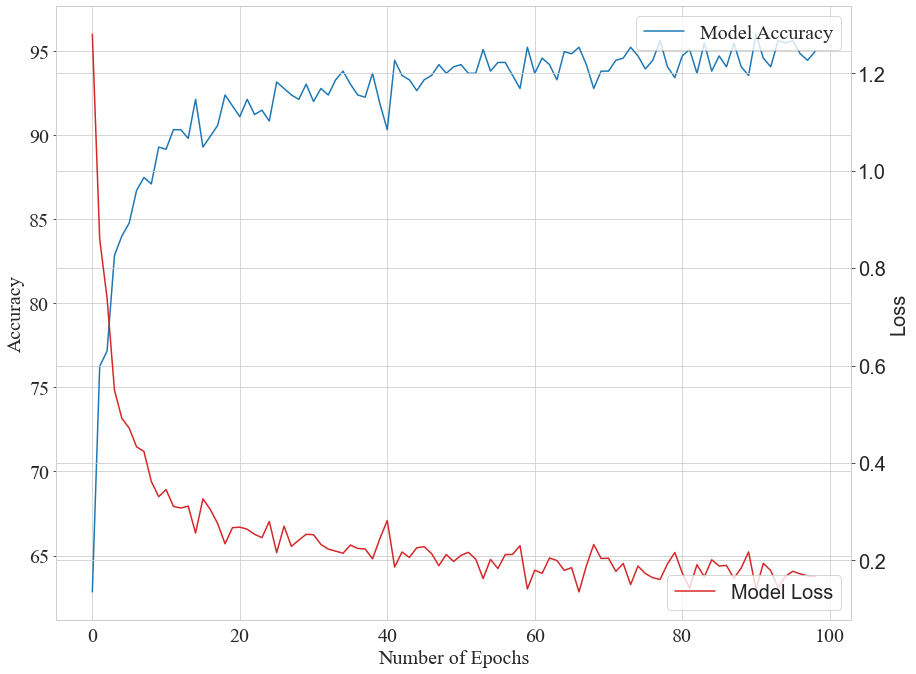

In [30]:
## Accuracy Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

color ='tab:blue'
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Epochs')
plt.plot(range(args.epochs -1), vali_acc_total)
ax.legend(['Model Accuracy'],fontsize=20, loc='upper right')
sns.set_style('whitegrid')

ax1 = ax.twinx()
color = 'tab:red'
ax1.set_ylabel('Loss')
ax1.plot(range(args.epochs -1), test_los_total, color = color)
ax1.legend(['Model Loss'], fontsize=20, loc='lower right')
sns.set_style('whitegrid')

# plt.savefig('./save/model_performance.png', bbox_inches = 'tight')

- - -

## Classification model test

In [ ]:
# Saving pytorch model

torch.save(model.state_dict(), 'C:/Users/user/Jupyter/ML_practices/vc_classic.pt')

In [ ]:
model_test = torch.load('C:/Users/user/Jupyter/ML_practices/vc_classic.pt')
# print(model_test)

* Model performance test process

In [ ]:
# Setting Optimizer and Objective Function

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = args.lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=30,anneal_strategy='cos')

# print(model)

In [ ]:
data_folder_path = 'E:/RESEARCH/Datasets/VC/classic/val'
# data_folder_path = 'E:/RESEARCH/Datasets/VC/sports/data/val'
test_dataset = datasets.ImageFolder(root=data_folder_path, transform=data_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
## Model testing
test_los_total = []
test_acc_total = []

for epoch in range(1, 30):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model_test, test_dataloader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))
    
    test_los_total.append(test_loss)
    test_acc_total.append(test_accuracy)

- - -

## Real-time classification

In [ ]:
datapath= r"E:\RESEARCH\Datasets\VC\sports\data"
outputmodel = r"E:\RESEARCH\Datasets\VC\sports\classificationModel"
outputlabelbinarizer = "E:\RESEARCH\Datasets\VC\sports\classificationBinarizer"
epochs=args.epochs